In [3]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score

from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfbml.methods.bayes_neural_nets import BNNWrapper
from mfpml.models.hierarchical_kriging import HierarchicalKriging

from mfpml.models.gaussian_process import GaussianProcessRegression
# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# read the data
data = pd.read_pickle("data.pkl")
# extract dataset
samples = data["samples"]
hf_samples = samples["hf"]
lf_samples = samples["lf"]
hf_responses = data["responses_lf1"]["hf"]
responses_lf1 = data["responses_lf1"]
responses_lf2 = data["responses_lf2"]
responses_lf3 = data["responses_lf3"]
test_samples = data["test_samples"]
test_hf_responses_noiseless = data["test_hf_responses_noiseless"]
test_hf_responses = data["test_hf_responses"]
test_lf1_responses = data["test_lf1_responses"]
test_lf2_responses = data["test_lf2_responses"]
test_lf3_responses = data["test_lf3_responses"]

In [27]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[50, 50],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses_scaled,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)
# save the model
with open("sf_bnn_model_50_50.pkl", "wb") as f:
    torch.save(bnn_model, f)

epoch:     0/20000
nll_loss: 325.160, prior_loss: 2506.826, total: 2831.986
noise: 0.123
epoch:   100/20000
nll_loss: 268.333, prior_loss: 2717.832, total: 2986.165
noise: 0.123
epoch:   200/20000
nll_loss: 268.374, prior_loss: 2841.891, total: 3110.265
noise: 0.123
epoch:   300/20000
nll_loss: 260.498, prior_loss: 2949.248, total: 3209.746
noise: 0.123
epoch:   400/20000
nll_loss: 250.816, prior_loss: 3044.343, total: 3295.159
noise: 0.123
epoch:   500/20000
nll_loss: 251.217, prior_loss: 3125.748, total: 3376.965
noise: 0.123
epoch:   600/20000
nll_loss: 247.497, prior_loss: 3209.223, total: 3456.720
noise: 0.123
epoch:   700/20000
nll_loss: 244.834, prior_loss: 3283.216, total: 3528.050
noise: 0.123
epoch:   800/20000
nll_loss: 231.067, prior_loss: 3314.587, total: 3545.655
noise: 0.123
epoch:   900/20000
nll_loss: 236.496, prior_loss: 3395.650, total: 3632.146
noise: 0.123
epoch:  1000/20000
nll_loss: 217.640, prior_loss: 3451.008, total: 3668.648
noise: 0.123
epoch:  1100/20000
nl

In [28]:
# load the model
with open("sf_bnn_model_50_50pkl.pkl", "rb") as f:
    bnn_model = torch.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'sf_bnn_model_50_50pkl.pkl'

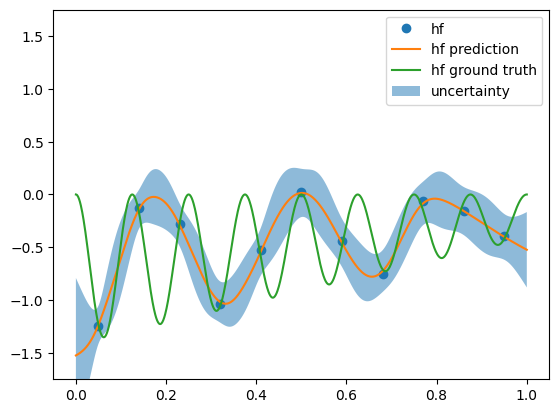

In [26]:
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    x=test_samples)
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")

plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# set the ylim
plt.ylim([-1.75, 1.75])
plt.legend()
plt.show()